In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def exit_velocity(P1, Pe, R, M, T1, k):
    """
    Calculate the exit velocity of a gas.

    Parameters:
    P1 (float): Initial pressure
    Pe (float): Exit pressure
    R (float): Specific gas constant
    M (float): Molar mass of the gas
    T1 (float): Initial temperature in Kelvin
    k (float): Specific heat ratio

    Returns:
    float: Exit velocity of the gas
    """
    # Validate inputs
    if P1 <= 0 or Pe <= 0 or T1 <= 0 or R <= 0 or M <= 0 or k <= 1:
        raise ValueError("All input parameters must be positive and k must be greater than 1.")

    # Calculate exit velocity using the formula
    Vexh = math.sqrt(2 * (k / (k - 1)) * (R / M) * T1 * (1 - (Pe / P1) ** ((k - 1) / k)))
    return Vexh

In [3]:
def chamber_pressure(mdot, At, R, M, T1, k):
    """
    Calculate the chamber pressure based on the given parameters.

    Parameters:
    mdot (float): Mass flow rate
    At (float): Throat area
    R (float): Specific gas constant
    M (float): Molar mass
    T1 (float): Temperature in Kelvin
    k (float): Specific heat ratio

    Returns:
    float: Chamber pressure
    """
    # Calculate the term inside the square root
    sqrt_term = math.sqrt(k * R * T1 / M)
    
    # Calculate the denominator term
    denominator = At * k * math.sqrt((2 / (k + 1)) ** ((k + 1) / (k - 1)))

    # Calculate chamber pressure
    Pch = mdot * sqrt_term / denominator
    
    return Pch

In [4]:
def calculate_thrust(P1, Pe, At, k):
    """
    Calculate the thrust based on the given parameters.

    Parameters:
    P1 (float): Initial pressure.
    Pe (float): Exit pressure.
    At (float): Throat area.
    k (float): Specific heat ratio.

    Returns:
    float: Calculated thrust force.
    """
    # Calculate the term involving pressures
    pressure_ratio = Pe / P1
    term1 = (k * k) / (k - 1)
    term2 = (2 / (k + 1)) ** ((k + 1) / (k - 1))
    
    # Calculate thrust force using the derived formula
    thrust_force = At * P1 * math.sqrt(2 * term1 * term2 * (1 - pressure_ratio ** ((k - 1) / k)))
    
    return thrust_force

In [5]:
# Constants
sqrt = math.sqrt
g = 9.81  # Acceleration due to gravity (m/s^2)
R = 8.314  # Universal gas constant (J/(mol*K))
M = 18 / 1000  # Molecular mass of exhaust (kg/mol)

# Assumed parameters
params = {
    'a': 0.00002,  # assumed
    'n': 0.8,  # assumed
    'rho_p': 900,  # kg/m^3
    'k': 1.13,  # Combustion products, assumed constant
    'T1': 3000,  # Temperature of combustion chamber (K)
    'mox': 0.9,  # Initial mass flow rate of oxidiser (kg/s)
    'At': 0.002,  # Area of throat (m^2)
    'Pe': 101325,  # Exit pressure (Pa)
    'rint': 0.065,  # Internal radius of grain (m)
    'rext': 0.080,  # External radius of grain (m)
    'L': 0.1,  # Length of combustion chamber (m)
    'dt': 0.0001,  # Time step (s)
    'tb': 20  # Total burn time (s)
}

# Derived parameters
ra = sqrt(params['At'] / np.pi)  # Radius of throat (m)
m_fuel = params['rho_p'] * np.pi * (params['rext']**2 - params['rint']**2) * params['L']  # Total fuel mass (kg)

# Initialize variables
mf = 0  # Fuel mass accumulated
tOF = 0  # Oxidiser to fuel ratio time
t_values = []  # Time values for tracking
F_values = []  # Thrust values for tracking
P1_values = []  # Chamber pressure values for tracking

# Time loop
for t in np.arange(0, params['tb'], params['dt']):
    G = params['mox'] / (np.pi * params['rint']**2)  # Mass flux
    dr = params['a'] * (G ** params['n']) * params['dt']  # Change in radius
    dmox = params['mox'] * params['dt']  # Change in oxidiser mass
    dmf = params['rho_p'] * 2 * np.pi * params['rint'] * params['L'] * dr  # Change in fuel mass
    dmt = dmox + dmf  # Total mass change
    mt = dmt / params['dt']  # Total mass flow rate
    tOF += dmox / dmf * params['dt']  # Update oxidiser to fuel ratio
    
    mf += dmf  # Accumulate fuel mass
    if mf >= m_fuel:
        break  # Stop if fuel mass is sufficient

    # Update throat radius
    params['rint'] += dr
    t_values.append(t)

    # Calculate chamber pressure and thrust
    P1 = chamber_pressure(mt, params['At'], R, M, params['T1'], params['k'])
    P1_values.append(P1)
    
    Ve = exit_velocity(P1, params['Pe'], R, M, params['T1'], params['k'])
    Isp = Ve / g  # Specific impulse
    F = calculate_thrust(P1, params['Pe'], params['At'], params['k'])
    F_values.append(F)

# Output results
print('Average Isp =', np.mean(Isp))
print('Fuel mass =', mf)
print('Burn time =', t)
print('Average thrust =', np.mean(F_values))
print('Oxidiser to fuel ratio =', tOF / t)
print("Radius of throat in cm =", ra * 100)

Average Isp = 233.56405869370255
Fuel mass = 0.6449666425475493
Burn time = 19.9999
Average thrust = 2139.247427844338
Oxidiser to fuel ratio = 28.996715699157992
Radius of throat in cm = 2.5231325220201604


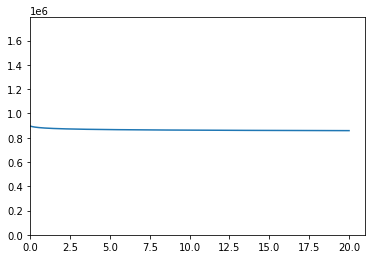

In [6]:
# Define variables with descriptive names
time_values = np.linspace(0, t, len(P1_values))
pressure_values = P1_values

# Create the plot
plt.plot(time_values, pressure_values)

# Set plot limits
plt.xlim(0, max(time_values) + 1)
plt.ylim(0, max(pressure_values) * 2)

# Show the plot (assuming this is what you want)
plt.show()

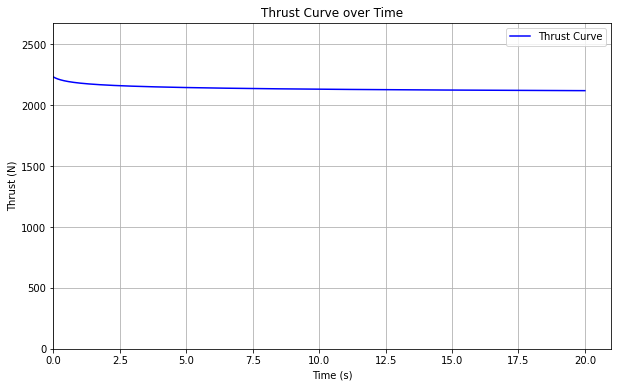

In [7]:
# Generate time values
size = len(F_values)
t_values = np.linspace(0, params['tb'], size)

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(t_values, F_values, label='Thrust Curve', color='blue')  # Added label and color

# Set the limits for the axes
plt.xlim(0, max(t_values) + 1)
plt.ylim(0, max(F_values) * 1.2)

# Add titles and labels
plt.title('Thrust Curve over Time')  # Add a title
plt.xlabel('Time (s)')  # Label for x-axis
plt.ylabel('Thrust (N)')  # Label for y-axis

# Add a grid for better readability
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.show()